In [1]:
import argparse

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision.models.resnet import resnet18

import torchvision.datasets as dset
import torchvision.transforms as T

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import numpy as np

In [2]:
## зададим настройки
class Args():
    batch_size = 128
    weight_decay = 0.0001
    print_every = 100


args = Args()

In [3]:
# get CIFAR-10 data
transform_augment = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4)])
transform_normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# dataloaders
NUM_TRAIN = 45000
NUM_VAL = 5000
cifar10_train = dset.CIFAR10('./dataset', train=True, download=True,
                                 transform=T.Compose([transform_augment, transform_normalize]))
loader_train = DataLoader(cifar10_train, batch_size=args.batch_size)
cifar10_val = dset.CIFAR10('./dataset', train=True, download=True,
                               transform=transform_normalize)
loader_val = DataLoader(cifar10_train, batch_size=args.batch_size)
cifar10_test = dset.CIFAR10('./dataset', train=False, download=True,
                                transform=transform_normalize)
loader_test = DataLoader(cifar10_test, batch_size=args.batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = resnet18(num_classes = 10)
#model.load_state_dict(torch.load('ResNet18_weight'))
model.to(device)
criterion = nn.CrossEntropyLoss().cuda()

global gpu_dtype
gpu_dtype = torch.cuda.FloatTensor

In [5]:
SCHEDULE_EPOCHS = [100, 50, 50] # divide lr by 10 after each number of epochs
learning_rate = 0.1

In [6]:
def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval()
    for X, y in loader:
        X_var = Variable(X.type(gpu_dtype), volatile=True)

        scores = model(X_var)
        _, preds = scores.data.cpu().max(1)

        num_correct += (preds == y).sum()
        num_samples += preds.size(0)

    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.4f)' % (num_correct, num_samples, acc))
    return acc

def train(loader_train, model, criterion, optimizer):
    loss_arr  = []
    model.train()
    for t, (X, y) in enumerate(loader_train):
        X_var = Variable(X.type(gpu_dtype))
        y_var = Variable(y.type(gpu_dtype)).long()

        scores = model(X_var)

        loss = criterion(scores, y_var)
        loss_arr += [loss.item()]
        #if (t+1) % args.print_every == 0:
        #    print('t = %d, loss = %.4f' % (t+1, loss.item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return  np.mean(loss_arr)

def plot_loss_and_accuracy(loss, acc):
    n = len(loss)
    f1, ax1 = plt.subplots(1, 1, sharey=True)
    ax1.plot(range(1,n+1), loss)
    ax1.set_title('Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    
    f2, ax2 = plt.subplots(1, 1, sharey=True)
    ax2.plot(range(n), acc)
    ax2.set_title('Accuracy')
    ax2.set_ylabel('acc')
    ax2.set_xlabel('epoch')
    
    plt.show()

def get_score(model, loader):
    predict_labels = np.array([])
    true_labels = np.array([])
    
    model.eval()
    for t, (X, y) in enumerate(loader):
        X_var = Variable(X.type(torch.FloatTensor), volatile=True)
        scores = model(X_var.to(device))
        _, preds = scores.data.max(1)
        predict_labels = np.append(predict_labels, preds.cpu().numpy())
        true_labels = np.append(true_labels, y.numpy())

    return predict_labels, true_labels

def predict(model, loader):
    predict_labels = np.array([[]])    
    model.eval()
    for t, (X, y) in enumerate(loader):
        X_var = Variable(X.type(torch.FloatTensor), volatile=True)
        preds = model(X_var.to(device))
        if t == 0:
            predict_labels = preds.cpu().detach().numpy()
        else:
            predict_labels = np.vstack((predict_labels,preds.cpu().detach().numpy()))

    return predict_labels

Starting epoch 50 / 50


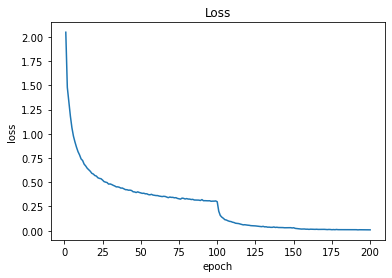

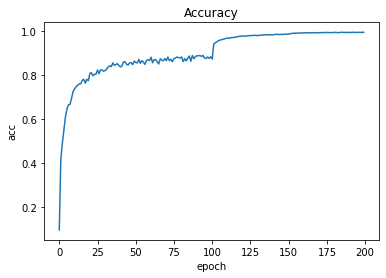

In [7]:
from IPython import display

loss  = []
acc = []
for num_epochs in SCHEDULE_EPOCHS:
    print('Training for %d epochs with learning rate %f' % (num_epochs, learning_rate))
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                          momentum=0.9, weight_decay=args.weight_decay)
    for epoch in range(num_epochs):
        acc += [check_accuracy(model, loader_val)]  
        loss += [train(loader_train, model, criterion, optimizer)]
        display.clear_output()
        print('Starting epoch %d / %d' % (epoch+1, num_epochs))
        plot_loss_and_accuracy(loss, acc)        
        torch.save(model.cpu().state_dict(), 'ResNet18_weight')
        model.to(device)
    learning_rate *= 0.1

In [8]:
acc[-1]

0.9938

## Построим Roc кривую

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [10]:
res , y_test = get_score(model, loader_test)
y_score = predict(model, loader_test)

/home/Katerina5649/Pulse/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/Katerina5649/Pulse/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


In [11]:
#example how to plot Roc curve - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

n_classes = 10
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


true = np.zeros(y_score.shape)
for i in range(y_score.shape[0]):
    j = int(res[i])
    true[i][j] = 1
    
y_test = true.astype(int)    
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/home/Katerina5649/Pulse/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


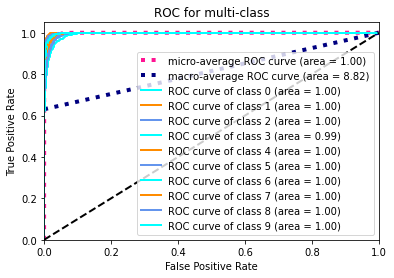

In [12]:
# First aggregate all false positive rates
all_fpr = np.array([0.,1.,2.,3.,4.,5.,6.,7.,8.,9.])
lw = 2

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class')
plt.legend(loc="lower right")
plt.show()